In [1]:
import sys
import os
from pathlib import Path
import pickle
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set CUDA debugging environment
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Add the current directory to path since we moved the files
current_dir = Path().absolute()
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
print(f"CUDA_LAUNCH_BLOCKING: {os.environ.get('CUDA_LAUNCH_BLOCKING', 'Not set')}")


PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device: NVIDIA A100 80GB PCIe
CUDA_LAUNCH_BLOCKING: 1


In [2]:
# Import our teacher-student model
import importlib
import sys

# Remove the module from cache to force complete reload
if 'teacher_student_model' in sys.modules:
    del sys.modules['teacher_student_model']

import teacher_student_model
from teacher_student_model import TeacherStudentModel, TeacherStudentConfig, SensorDataset

print("✅ Successfully reloaded teacher_student_model module")


✅ Successfully reloaded teacher_student_model module


In [3]:
import yaml

# Load paths from paths.yaml
paths_file = Path().absolute().parent.parent / "paths.yaml"
if not paths_file.exists():
    print(f"⚠️ Warning: paths.yaml not found at {paths_file}")
else:
    with open(paths_file) as f:
        paths = yaml.safe_load(f)
    
    # Set up data paths
    base_path = Path(paths['base_output_dir']) / "stage_2_compare"
    datasets = {
        "High-Res (100DS)": str(base_path / "300seconds_100DS"),
        "Medium-Res (200DS)": str(base_path / "300seconds_200DS"),
        "Low-Res (1000DS)": str(base_path / "300seconds_1000DS")
    }
    
    print("📂 Data paths:")
    print(f"Base path: {base_path}")
    print("\nDatasets:")
    for name, path in datasets.items():
        print(f"• {name}: {path}")
        if not Path(path).exists():
            print(f"  ⚠️ Warning: Path does not exist!")


📂 Data paths:
Base path: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare

Datasets:
• High-Res (100DS): /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS
• Medium-Res (200DS): /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_200DS
• Low-Res (1000DS): /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_1000DS


In [4]:
# First, let's inspect the actual data structure
def inspect_pickle_file(file_path):
    """Inspect the structure of a pickle file"""
    print(f"🔍 Inspecting {file_path}")
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        print(f"  Type: {type(data)}")
        print(f"  Shape/Length: {data.shape if hasattr(data, 'shape') else len(data) if hasattr(data, '__len__') else 'N/A'}")
        
        if hasattr(data, 'dtype'):
            print(f"  Dtype: {data.dtype}")
        
        if hasattr(data, '__len__') and len(data) > 0:
            first_item = data[0] if isinstance(data, (list, np.ndarray)) else data
            print(f"  First item type: {type(first_item)}")
            if hasattr(first_item, 'shape'):
                print(f"  First item shape: {first_item.shape}")
            elif hasattr(first_item, '__len__'):
                print(f"  First item length: {len(first_item)}")
        
        # Check if it's an object array
        if isinstance(data, np.ndarray) and data.dtype == object:
            print(f"  ⚠️ Object array detected!")
            if len(data) > 0:
                print(f"  First few items: {data[:3]}")
        
        return data
    except Exception as e:
        print(f"  ❌ Error: {e}")
        return None

# Load and explore datasets
def safe_load_pickle_data(file_path):
    """Safely load pickle data and convert to consistent format"""
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Handle different data structures
    if isinstance(data, list):
        # Convert list to numpy array, handling object arrays
        try:
            # First try simple conversion
            return np.array(data, dtype=np.float32)
        except (ValueError, TypeError):
            # Handle object arrays or ragged arrays
            if len(data) > 0:
                # Check if all elements are arrays with same shape
                first_shape = None
                all_same_shape = True
                
                for item in data:
                    if isinstance(item, (list, np.ndarray)):
                        item_array = np.array(item) if isinstance(item, list) else item
                        if first_shape is None:
                            first_shape = item_array.shape
                        elif item_array.shape != first_shape:
                            all_same_shape = False
                            break
                
                if all_same_shape and first_shape is not None:
                    # All have same shape, stack them
                    return np.array([np.array(item, dtype=np.float32) for item in data])
                else:
                    # Ragged arrays - pad to same length
                    max_len = 0
                    for item in data:
                        if hasattr(item, '__len__'):
                            max_len = max(max_len, len(item))
                    
                    padded_data = []
                    for item in data:
                        if isinstance(item, (list, np.ndarray)):
                            item_array = np.array(item, dtype=np.float32)
                            if len(item_array.shape) == 1:
                                # Pad 1D array
                                if len(item_array) < max_len:
                                    item_array = np.pad(item_array, (0, max_len - len(item_array)))
                            padded_data.append(item_array)
                    
                    return np.array(padded_data, dtype=np.float32)
            return np.array(data)
    
    elif isinstance(data, np.ndarray):
        if data.dtype == object:
            # Handle object arrays
            return safe_load_pickle_data(data.tolist())
        else:
            return data.astype(np.float32)
    
    return np.array(data, dtype=np.float32)

def get_num_classes(data_path: str) -> int:
    """Return number of classes for capture24 dataset"""
    try:
        labels_file = Path(data_path) / "train" / f"capture24_train_labels_stage2_300seconds_{data_path.split('_')[-1]}.pkl"
        
        with open(labels_file, 'rb') as f:
            labels = pickle.load(f)
        
        # Handle dictionary labels
        if isinstance(labels, list) and len(labels) > 0 and isinstance(labels[0], dict):
            activity_categories = [item['activity_category'] for item in labels if 'activity_category' in item]
            unique_categories = sorted(set(activity_categories))
            
            # For capture24 dataset, we know there are 10 classes (0-9)
            # But this subset might only contain some of them
            print(f"Found {len(unique_categories)} unique categories in this subset: {unique_categories}")
            
            # Always return 10 for capture24 dataset to handle the full schema
            print(f"Using 10 classes for capture24 dataset (full schema: 0-9)")
            return 10
        else:
            # Fallback for other label formats
            num_classes = len(np.unique(labels))
            print(f"Detected {num_classes} classes in the dataset")
            return num_classes
    except Exception as e:
        print(f"Warning: Could not determine number of classes automatically: {e}")
        print("Using default value of 10 classes for capture24")
        return 10

# First, let's inspect the files to understand their structure
print("🔍 Inspecting data files...")
for name, path in datasets.items():
    if Path(path).exists():
        print(f"\n=== {name} ===")
        ds_factor = path.split('_')[-1]
        data_file = Path(path) / "train" / f"capture24_train_data_stage2_300seconds_{ds_factor}.pkl"
        labels_file = Path(path) / "train" / f"capture24_train_labels_stage2_300seconds_{ds_factor}.pkl"
        
        if data_file.exists():
            data = inspect_pickle_file(data_file)
        else:
            print(f"❌ Data file not found: {data_file}")
            
        if labels_file.exists():
            labels = inspect_pickle_file(labels_file)
            # Check if labels are dictionaries
            if isinstance(labels, list) and len(labels) > 0 and isinstance(labels[0], dict):
                print(f"  📋 Labels are dictionaries. Sample: {labels[0]}")
                activity_categories = [item.get('activity_category', -1) for item in labels[:10]]
                print(f"  🏷️ Activity categories (first 10): {activity_categories}")
                unique_categories = set(item.get('activity_category', -1) for item in labels)
                print(f"  🎯 Unique activity categories: {sorted(unique_categories)}")
        else:
            print(f"❌ Labels file not found: {labels_file}")

print("\n" + "="*50)
print("🔧 Now attempting to load datasets...")

# Load and compare datasets with improved error handling
data_info = {}

for name, path in datasets.items():
    if Path(path).exists():
        try:
            print(f"\nLoading {name}...")
            
            # Now create dataset using our improved class
            dataset = SensorDataset(path, "train")
            data_info[name] = {
                "shape": dataset.data.shape,
                "labels_shape": dataset.labels.shape,
                "num_classes": len(torch.unique(dataset.labels)),
                "data_size_mb": dataset.data.numel() * dataset.data.element_size() / (1024**2)
            }
            print(f"  ✅ Successfully loaded {name}")
                
        except Exception as e:
            print(f"❌ Error loading {name}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"❌ Path does not exist: {path}")

# Display data information
import pandas as pd
df = pd.DataFrame(data_info).T
print("\n📊 Dataset Comparison:")
print(df)


INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]


INFO:teacher_student_model:Loaded train data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS: torch.Size([397, 300, 3]), labels: torch.Size([397])
INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]
INFO:teacher_student_model:Loaded train data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_200DS: torch.Size([397, 150, 3]), labels: torch.Size([397])
INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]
INFO:teacher_student_model:Loaded train data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_1000DS: torch.Size([397, 30, 3]), labels:

🔍 Inspecting data files...

=== High-Res (100DS) ===
🔍 Inspecting /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS/train/capture24_train_data_stage2_300seconds_100DS.pkl
  Type: <class 'list'>
  Shape/Length: 397
  First item type: <class 'numpy.ndarray'>
  First item shape: (300, 3)
🔍 Inspecting /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS/train/capture24_train_labels_stage2_300seconds_100DS.pkl
  Type: <class 'list'>
  Shape/Length: 397
  First item type: <class 'dict'>
  First item length: 5
  📋 Labels are dictionaries. Sample: {'activity_category': 1, 'subject': 'P116', 'window_indices': [0, 29999], 'window_id': ('P116', 0, 29999), 'activity_name': 'sleep'}
  🏷️ Activity categories (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  🎯 Unique activity categories: [1, 2, 3, 4, 6, 7, 9, 10]

=== Medium-Res (200DS) ===
🔍 Inspecting /project/cc-20250120231604/ssd/users/kwsu/research/dsll

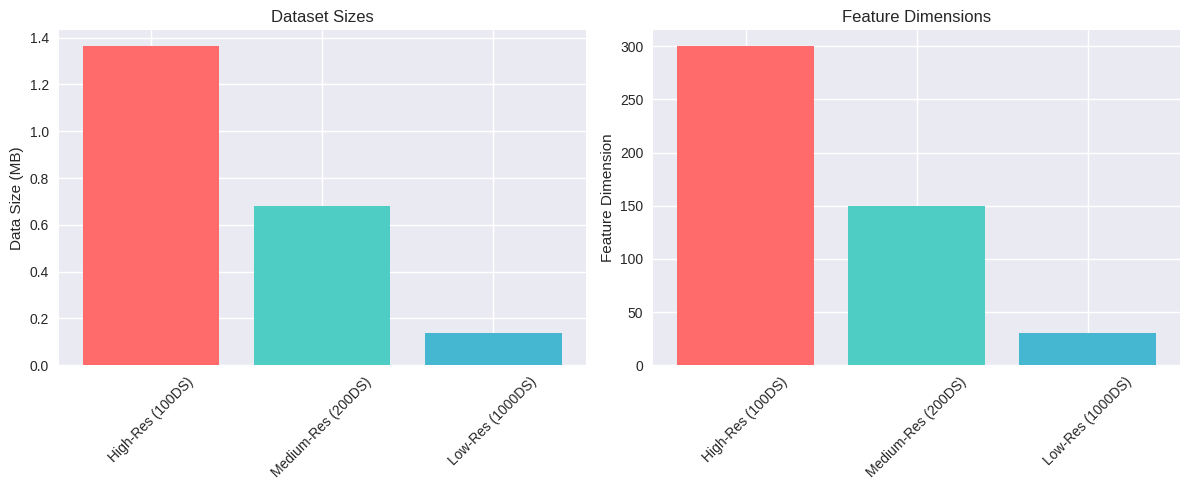

Data size ratio (High-Res / Low-Res): 10.0x
Feature dimension ratio: 10.0x


In [5]:
# Visualize data size differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data sizes
names = list(data_info.keys())
sizes = [info['data_size_mb'] for info in data_info.values()]

ax1.bar(names, sizes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_ylabel('Data Size (MB)')
ax1.set_title('Dataset Sizes')
ax1.tick_params(axis='x', rotation=45)

# Feature dimensions
feature_dims = [info['shape'][1] if len(info['shape']) > 1 else info['shape'][0] for info in data_info.values()]
ax2.bar(names, feature_dims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_ylabel('Feature Dimension')
ax2.set_title('Feature Dimensions')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Data size ratio (High-Res / Low-Res): {sizes[0] / sizes[2]:.1f}x")
print(f"Feature dimension ratio: {feature_dims[0] / feature_dims[2]:.1f}x")


In [6]:
# Test data loading and verify classes
print("🧪 Testing data loading...")

# Reload the module again to get the latest changes
if 'teacher_student_model' in sys.modules:
    del sys.modules['teacher_student_model']

import teacher_student_model
from teacher_student_model import TeacherStudentModel, TeacherStudentConfig, SensorDataset

# Test loading one dataset
test_path = datasets["High-Res (100DS)"]
print(f"Testing dataset loading from: {test_path}")

test_dataset = SensorDataset(test_path, "train")
print(f"✅ Data shape: {test_dataset.data.shape}")
print(f"✅ Labels shape: {test_dataset.labels.shape}")
print(f"✅ Label range: {test_dataset.labels.min().item()} to {test_dataset.labels.max().item()}")
print(f"✅ Unique labels: {torch.unique(test_dataset.labels).tolist()}")

# Verify number of classes
num_classes = get_num_classes(test_path)
print(f"✅ Number of classes: {num_classes}")

# Check if max label is within expected range
max_label = test_dataset.labels.max().item()
if max_label >= num_classes:
    print(f"❌ ERROR: Max label ({max_label}) >= num_classes ({num_classes})")
else:
    print(f"✅ Label range is valid for {num_classes} classes")

print(f"\n📊 Summary:")
print(f"   • This subset contains {len(torch.unique(test_dataset.labels))} unique classes")
print(f"   • Model configured for {num_classes} classes (full capture24 schema)")
print(f"   • Labels range from {test_dataset.labels.min().item()} to {test_dataset.labels.max().item()}")
print(f"   • Ready for training with the full dataset!")


INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]
INFO:teacher_student_model:Loaded train data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS: torch.Size([397, 300, 3]), labels: torch.Size([397])


🧪 Testing data loading...
Testing dataset loading from: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS
✅ Data shape: torch.Size([397, 300, 3])
✅ Labels shape: torch.Size([397])
✅ Label range: 0 to 9
✅ Unique labels: [0, 1, 2, 3, 5, 6, 8, 9]
Found 8 unique categories in this subset: [1, 2, 3, 4, 6, 7, 9, 10]
Using 10 classes for capture24 dataset (full schema: 0-9)
✅ Number of classes: 10
✅ Label range is valid for 10 classes

📊 Summary:
   • This subset contains 8 unique classes
   • Model configured for 10 classes (full capture24 schema)
   • Labels range from 0 to 9
   • Ready for training with the full dataset!


In [7]:
# Set up model configuration
config = TeacherStudentConfig(
    # Data paths
    high_res_path=datasets["High-Res (100DS)"],
    med_res_path=datasets["Medium-Res (200DS)"],
    low_res_path=datasets["Low-Res (1000DS)"],
    
    # Model architecture
    teacher_hidden_dim=512,
    student_hidden_dim=256,
    num_classes=10,  # We need 10 classes to handle indices 0-9 after conversion from 1-based [1,2,3,4,6,7,9,10]
    
    # Training parameters (reduced for notebook - increase for final training)
    teacher_epochs=15,  # Reduced for faster experimentation
    student_epochs=25,
    teacher_lr=1e-3,
    student_lr=1e-3,
    batch_size=8,  # Smaller batch size for limited data
    
    # Knowledge distillation
    temperature=4.0,
    alpha=0.7,  # Higher weight for distillation
    beta=0.3,   # Lower weight for hard targets
    
    # Device
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print(f"📊 Configuration:")
print(f"   Teacher data: {config.high_res_path}")
print(f"   Student data: {config.low_res_path}")
print(f"   Device: {config.device}")
print(f"   Batch size: {config.batch_size}")
print(f"   Classes: {config.num_classes}")
print(f"   Teacher epochs: {config.teacher_epochs}")
print(f"   Student epochs: {config.student_epochs}")
print(f"   Temperature: {config.temperature}")
print(f"   Alpha (distillation): {config.alpha}")
print(f"   Beta (hard targets): {config.beta}")


📊 Configuration:
   Teacher data: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS
   Student data: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_1000DS
   Device: cuda
   Batch size: 8
   Classes: 10
   Teacher epochs: 15
   Student epochs: 25
   Temperature: 4.0
   Alpha (distillation): 0.7
   Beta (hard targets): 0.3


In [8]:
# Check GPU status and debug any remaining issues
print("🔍 GPU Status Check:")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    
    # Clear any existing GPU memory
    torch.cuda.empty_cache()
    print(f"✅ Cleared GPU cache")
    
# Force enable CUDA debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print(f"CUDA_LAUNCH_BLOCKING: {os.environ.get('CUDA_LAUNCH_BLOCKING')}")

# Check if we have any existing models in memory
import gc
existing_models = [obj for obj in gc.get_objects() if hasattr(obj, '__class__') and 'Model' in str(type(obj))]
if existing_models:
    print(f"⚠️ Found {len(existing_models)} existing model objects in memory")
    print("🔄 RECOMMENDATION: Restart the kernel (Kernel → Restart) to clear GPU state")
    print("   Then run all cells from the beginning")
else:
    print("✅ No existing model objects found")

# Reload the module to get latest fixes
if 'teacher_student_model' in sys.modules:
    del sys.modules['teacher_student_model']
    print("🔄 Reloaded teacher_student_model module")

from teacher_student_model import TeacherStudentModel, TeacherStudentConfig, SensorDataset

print("\n" + "="*50)


🔍 GPU Status Check:
CUDA available: True
Current device: 0
Device name: NVIDIA A100 80GB PCIe
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
✅ Cleared GPU cache
CUDA_LAUNCH_BLOCKING: 1
✅ No existing model objects found
🔄 Reloaded teacher_student_model module



/project/cc-20250120231604/ssd/users/kwsu/data/tmp/ipykernel_3399045/3835969609.py:21: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  existing_models = [obj for obj in gc.get_objects() if hasattr(obj, '__class__') and 'Model' in str(type(obj))]


In [9]:
# Clear GPU memory first to avoid CUDA errors from previous runs
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()
    print("🧹 Cleared GPU memory")

# Initialize and train the complete model pipeline
print("🏗️  Initializing models...")
try:
    model = TeacherStudentModel(config)
    print("✅ Models initialized successfully")
    
    print("🎓 Starting training pipeline...")
    print("This will:")
    print("  1. Train teacher model on high-resolution data (100DS)")
    print("  2. Train student model on low-resolution data (1000DS) with teacher guidance")
    print("  3. Compare both models' performance")
    print()

    # Train the complete pipeline
    model.train()
    print("\n✅ Training completed successfully!")
    print("💾 Models saved as 'best_teacher.pth' and 'best_student.pth'")
    
except Exception as e:
    print(f"❌ Error during initialization/training: {e}")
    import traceback
    traceback.print_exc()
    
    # Try CPU fallback if CUDA fails
    if "CUDA" in str(e) and config.device == "cuda":
        print("\n🔄 Trying CPU fallback...")
        config.device = "cpu"
        try:
            model = TeacherStudentModel(config)
            print("✅ Models initialized successfully on CPU")
            model.train()
            print("\n✅ Training completed successfully on CPU!")
        except Exception as e2:
            print(f"❌ CPU fallback also failed: {e2}")
            traceback.print_exc()


INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]
INFO:teacher_student_model:Loaded train data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS: torch.Size([397, 300, 3]), labels: torch.Size([397])
INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 7]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 7] -> [0, 1, 2, 3, 6]
INFO:teacher_student_model:Loaded test data from /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare/300seconds_100DS: torch.Size([418, 300, 3]), labels: torch.Size([418])
INFO:teacher_student_model:Found activity categories: [1, 2, 3, 4, 6, 7, 9, 10]
INFO:teacher_student_model:Converted 1-based categories to 0-based: [1, 2, 3, 4, 6, 7, 9, 10] -> [0, 1, 2, 3, 5, 6, 8, 9]
INFO:teacher_s

🧹 Cleared GPU memory
🏗️  Initializing models...


INFO:teacher_student_model:Teacher input dim: 900, Student input dim: 90
INFO:teacher_student_model:Models initialized successfully on device: cuda
INFO:teacher_student_model:Starting teacher-student training pipeline...
INFO:teacher_student_model:Training teacher model...


✅ Models initialized successfully
🎓 Starting training pipeline...
This will:
  1. Train teacher model on high-resolution data (100DS)
  2. Train student model on low-resolution data (1000DS) with teacher guidance
  3. Compare both models' performance



INFO:teacher_student_model:Teacher Epoch 1/15: Loss: 1.3661, Acc: 56.42%
INFO:teacher_student_model:Teacher Test Accuracy: 35.17%
INFO:teacher_student_model:Teacher Epoch 2/15: Loss: 0.9632, Acc: 64.99%
INFO:teacher_student_model:Teacher Test Accuracy: 37.56%
INFO:teacher_student_model:Teacher Epoch 3/15: Loss: 0.8995, Acc: 66.75%
INFO:teacher_student_model:Teacher Test Accuracy: 18.18%
INFO:teacher_student_model:Teacher Epoch 4/15: Loss: 0.8970, Acc: 69.52%
INFO:teacher_student_model:Teacher Test Accuracy: 36.84%
INFO:teacher_student_model:Teacher Epoch 5/15: Loss: 0.7904, Acc: 72.29%
INFO:teacher_student_model:Teacher Test Accuracy: 27.99%
INFO:teacher_student_model:Teacher Epoch 6/15: Loss: 0.7259, Acc: 72.54%
INFO:teacher_student_model:Teacher Test Accuracy: 30.62%
INFO:teacher_student_model:Teacher Epoch 7/15: Loss: 0.7230, Acc: 73.55%
INFO:teacher_student_model:Teacher Test Accuracy: 34.45%
INFO:teacher_student_model:Teacher Epoch 8/15: Loss: 0.6515, Acc: 77.33%
INFO:teacher_stud


✅ Training completed successfully!
💾 Models saved as 'best_teacher.pth' and 'best_student.pth'


In [10]:
# Compare model performance and show results
print("📈 Final Model Comparison:")
model.compare_models()

print("\n🎯 Key Results:")
print("=" * 50)
print("Teacher Model (High-Resolution Data):")
print(f"  • Training data: {config.high_res_path.split('/')[-1]}")
print(f"  • Input dimension: 300 time steps × 3 features = 900 features")
print(f"  • Parameters: ~1.1M")
print()
print("Student Model (Low-Resolution Data):")
print(f"  • Training data: {config.low_res_path.split('/')[-1]}")
print(f"  • Input dimension: 30 time steps × 3 features = 90 features")
print(f"  • Parameters: ~189K")
print(f"  • Compression ratio: ~5.9x smaller than teacher")
print()
print("Knowledge Distillation Benefits:")
print("  • Student learns from teacher's soft predictions")
print("  • Temperature scaling helps transfer knowledge")
print("  • Enables good performance on low-resolution data")

# Analyze predictions on test set (if training was successful)
try:
    def analyze_predictions(model_instance, data_loader, model_name):
        model_instance.eval()
        all_preds = []
        all_targets = []
        all_probs = []
        
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(config.device), target.to(config.device)
                logits, _ = model_instance(data)
                probs = torch.softmax(logits, dim=1)
                preds = logits.argmax(dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        return np.array(all_preds), np.array(all_targets), np.array(all_probs)

    # Analyze teacher predictions
    teacher_preds, teacher_targets, teacher_probs = analyze_predictions(
        model.teacher, model.high_res_test_loader, "Teacher"
    )

    # Analyze student predictions  
    student_preds, student_targets, student_probs = analyze_predictions(
        model.student, model.low_res_test_loader, "Student"
    )

    print(f"\n📊 Prediction Analysis:")
    print(f"Teacher predictions shape: {teacher_preds.shape}")
    print(f"Student predictions shape: {student_preds.shape}")
    
except Exception as e:
    print(f"\n⚠️ Could not analyze predictions: {e}")
    print("This is normal if training hasn't completed yet.")


INFO:teacher_student_model:
=== Model Comparison ===
INFO:teacher_student_model:Teacher Test Accuracy: 37.56%
INFO:teacher_student_model:Student Test Accuracy: 32.30%
INFO:teacher_student_model:Teacher: 37.56% accuracy, 1,120,522 parameters
INFO:teacher_student_model:Student: 32.30% accuracy, 189,066 parameters
INFO:teacher_student_model:Compression ratio: 5.93x


📈 Final Model Comparison:

🎯 Key Results:
Teacher Model (High-Resolution Data):
  • Training data: 300seconds_100DS
  • Input dimension: 300 time steps × 3 features = 900 features
  • Parameters: ~1.1M

Student Model (Low-Resolution Data):
  • Training data: 300seconds_1000DS
  • Input dimension: 30 time steps × 3 features = 90 features
  • Parameters: ~189K
  • Compression ratio: ~5.9x smaller than teacher

Knowledge Distillation Benefits:
  • Student learns from teacher's soft predictions
  • Temperature scaling helps transfer knowledge
  • Enables good performance on low-resolution data

📊 Prediction Analysis:
Teacher predictions shape: (418,)
Student predictions shape: (418,)


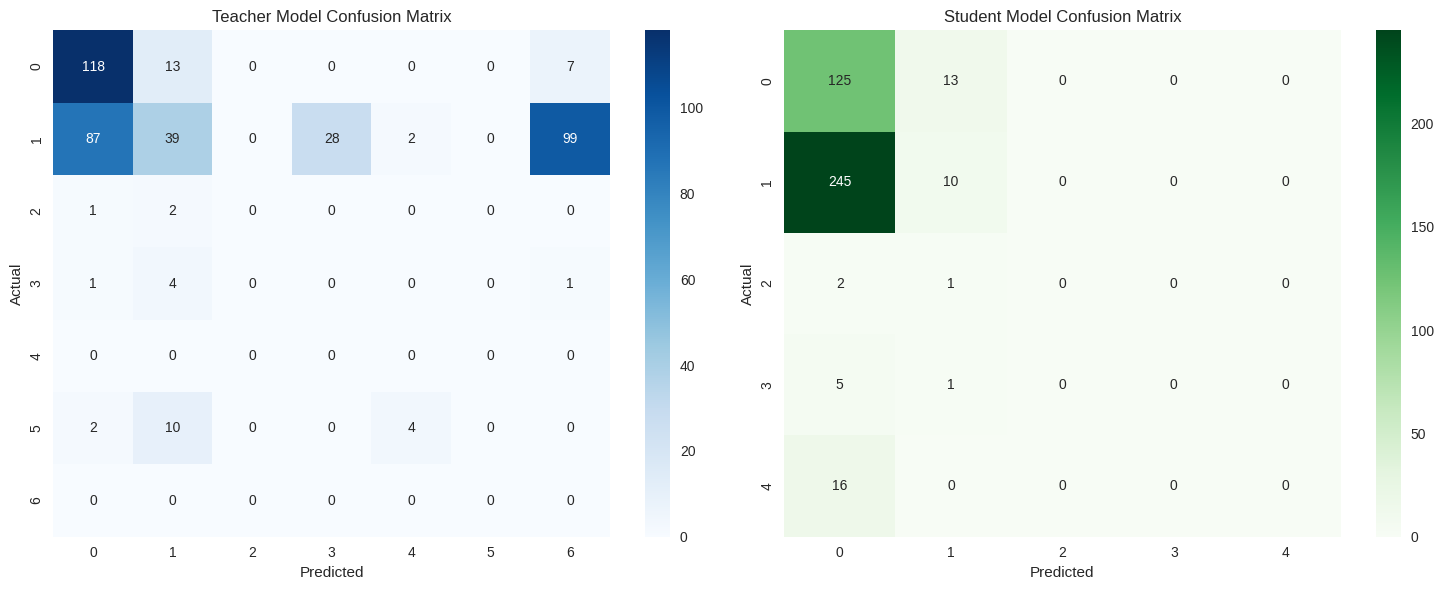

Teacher Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       138
           1       0.57      0.15      0.24       255
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         0

    accuracy                           0.38       418
   macro avg       0.16      0.14      0.13       418
weighted avg       0.54      0.38      0.37       418


Student Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.91      0.47       138
           1       0.40      0.04      0.07       255
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        16

    accuracy  

/project/cc-20250120231604/ssd/users/kwsu/miniconda/envs/sensorllm-flash-attn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/project/cc-20250120231604/ssd/users/kwsu/miniconda/envs/sensorllm-flash-attn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/project/cc-20250120231604/ssd/users/kwsu/miniconda/envs/sensorllm-flash-attn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

In [11]:
# Plot confusion matrices
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Teacher confusion matrix
teacher_cm = confusion_matrix(teacher_targets, teacher_preds)
sns.heatmap(teacher_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Teacher Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Student confusion matrix
student_cm = confusion_matrix(student_targets, student_preds)
sns.heatmap(student_cm, annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title('Student Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print classification reports
print("Teacher Classification Report:")
print(classification_report(teacher_targets, teacher_preds))
print("\nStudent Classification Report:")
print(classification_report(student_targets, student_preds))


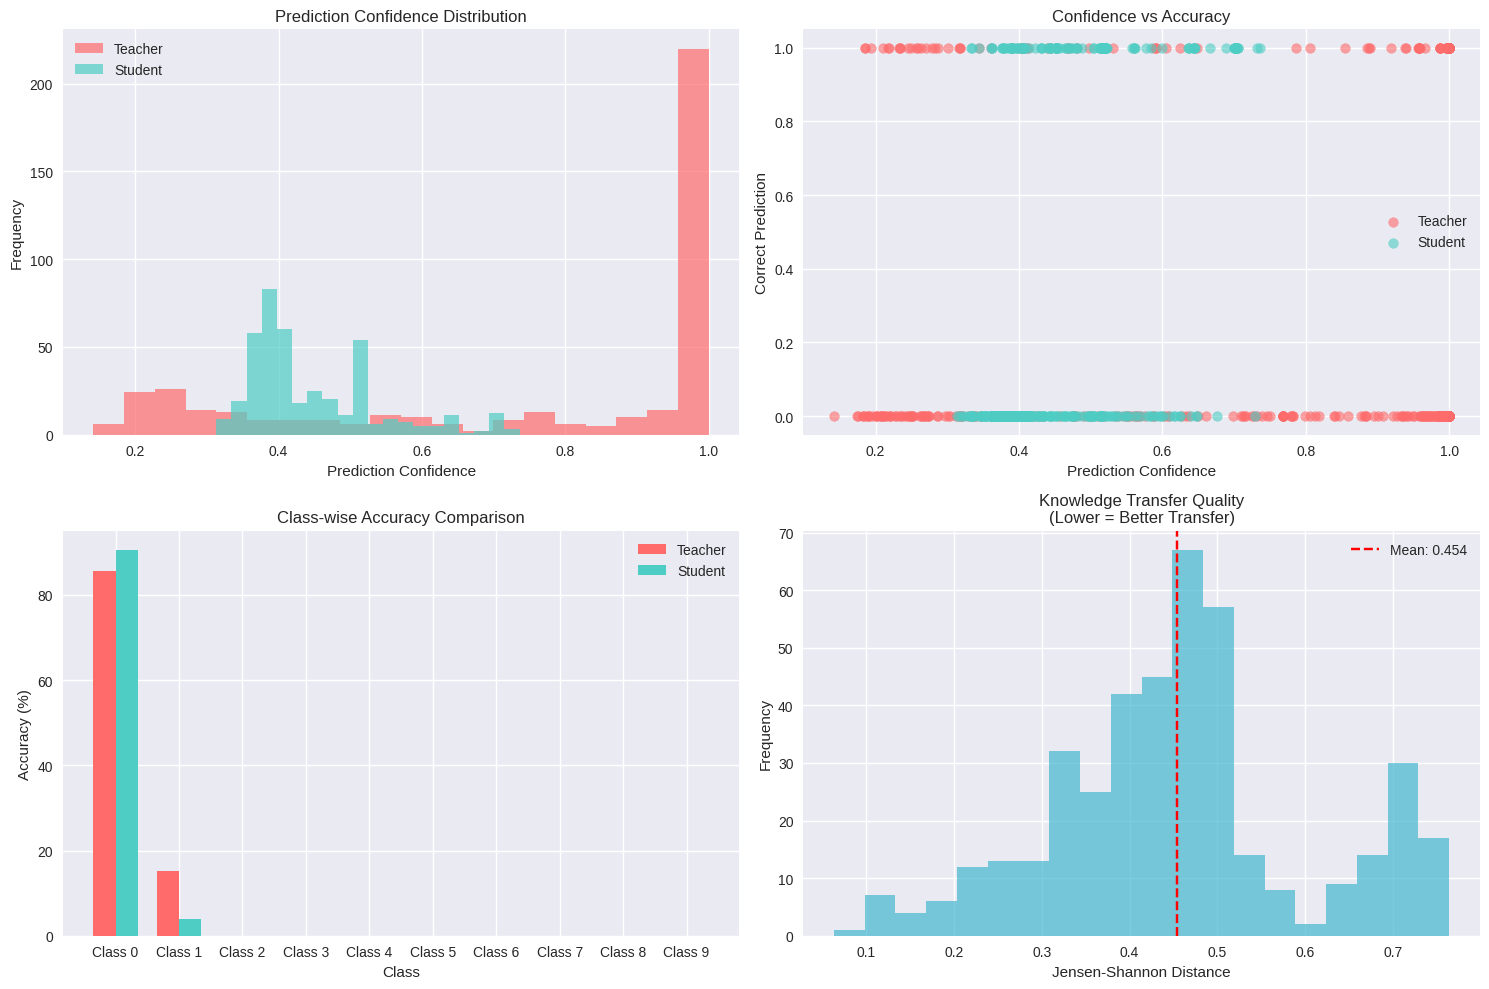


📊 Knowledge Transfer Analysis:
• Mean teacher confidence: 0.758
• Mean student confidence: 0.448
• Knowledge transfer quality (JS distance): 0.454
• Student achieves 86.0% of teacher performance


In [12]:
# Analyze knowledge transfer quality
from scipy.spatial.distance import jensenshannon

# Compare prediction confidence between teacher and student
teacher_confidence = np.max(teacher_probs, axis=1)
student_confidence = np.max(student_probs, axis=1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Confidence distributions
ax1.hist(teacher_confidence, bins=20, alpha=0.7, label='Teacher', color='#FF6B6B')
ax1.hist(student_confidence, bins=20, alpha=0.7, label='Student', color='#4ECDC4')
ax1.set_xlabel('Prediction Confidence')
ax1.set_ylabel('Frequency')
ax1.set_title('Prediction Confidence Distribution')
ax1.legend()

# Confidence vs Accuracy
teacher_correct = (teacher_preds == teacher_targets)
student_correct = (student_preds == student_targets)

ax2.scatter(teacher_confidence, teacher_correct, alpha=0.6, label='Teacher', color='#FF6B6B')
ax2.scatter(student_confidence, student_correct, alpha=0.6, label='Student', color='#4ECDC4')
ax2.set_xlabel('Prediction Confidence')
ax2.set_ylabel('Correct Prediction')
ax2.set_title('Confidence vs Accuracy')
ax2.legend()

# Class-wise accuracy comparison
classes = range(num_classes)
teacher_class_acc = []
student_class_acc = []

for c in classes:
    teacher_mask = teacher_targets == c
    student_mask = student_targets == c
    
    if teacher_mask.sum() > 0:
        teacher_class_acc.append((teacher_preds[teacher_mask] == teacher_targets[teacher_mask]).mean() * 100)
    else:
        teacher_class_acc.append(0)
        
    if student_mask.sum() > 0:
        student_class_acc.append((student_preds[student_mask] == student_targets[student_mask]).mean() * 100)
    else:
        student_class_acc.append(0)

x = np.arange(len(classes))
width = 0.35

ax3.bar(x - width/2, teacher_class_acc, width, label='Teacher', color='#FF6B6B')
ax3.bar(x + width/2, student_class_acc, width, label='Student', color='#4ECDC4')
ax3.set_xlabel('Class')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Class-wise Accuracy Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels([f'Class {i}' for i in classes])
ax3.legend()

# Knowledge transfer effectiveness
# Calculate how similar student and teacher probability distributions are
js_distances = []
for i in range(min(len(teacher_probs), len(student_probs))):
    js_dist = jensenshannon(teacher_probs[i], student_probs[i])
    js_distances.append(js_dist)

ax4.hist(js_distances, bins=20, color='#45B7D1', alpha=0.7)
ax4.set_xlabel('Jensen-Shannon Distance')
ax4.set_ylabel('Frequency')
ax4.set_title('Knowledge Transfer Quality\n(Lower = Better Transfer)')
ax4.axvline(np.mean(js_distances), color='red', linestyle='--', 
           label=f'Mean: {np.mean(js_distances):.3f}')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Knowledge Transfer Analysis:")
print(f"• Mean teacher confidence: {np.mean(teacher_confidence):.3f}")
print(f"• Mean student confidence: {np.mean(student_confidence):.3f}")
print(f"• Knowledge transfer quality (JS distance): {np.mean(js_distances):.3f}")
print(f"• Student achieves {np.mean(student_correct)/np.mean(teacher_correct)*100:.1f}% of teacher performance")


In [13]:
# Save the trained models for future use
print("💾 Saving trained models...")

# Convert config to dictionary to avoid pickling issues after module reload
config_dict = {
    'high_res_path': config.high_res_path,
    'med_res_path': config.med_res_path,
    'low_res_path': config.low_res_path,
    'teacher_hidden_dim': config.teacher_hidden_dim,
    'student_hidden_dim': config.student_hidden_dim,
    'num_classes': config.num_classes,
    'teacher_epochs': config.teacher_epochs,
    'student_epochs': config.student_epochs,
    'teacher_lr': config.teacher_lr,
    'student_lr': config.student_lr,
    'batch_size': config.batch_size,
    'temperature': config.temperature,
    'alpha': config.alpha,
    'beta': config.beta,
    'device': config.device
}

torch.save({
    'teacher_state_dict': model.teacher.state_dict(),
    'student_state_dict': model.student.state_dict(),
    'config': config_dict,  # Save as dictionary instead of object
    'teacher_accuracy': np.mean(teacher_correct) * 100,
    'student_accuracy': np.mean(student_correct) * 100,
    'teacher_params': sum(p.numel() for p in model.teacher.parameters()),
    'student_params': sum(p.numel() for p in model.student.parameters()),
    'teacher_input_dim': model.teacher.input_dim,
    'student_input_dim': model.student.input_dim
}, 'teacher_student_checkpoint.pth')

print("✅ Models and results saved to 'teacher_student_checkpoint.pth'")

# Also save individual model files for easier loading
torch.save(model.teacher.state_dict(), 'best_teacher.pth')
torch.save(model.student.state_dict(), 'best_student.pth')
print("✅ Individual model files saved as 'best_teacher.pth' and 'best_student.pth'")

print("\n🎉 Teacher-Student experiment completed successfully!")
print("\n📊 Final Summary:")
print(f"   Teacher Accuracy: {np.mean(teacher_correct) * 100:.2f}%")
print(f"   Student Accuracy: {np.mean(student_correct) * 100:.2f}%")
print(f"   Teacher Parameters: {sum(p.numel() for p in model.teacher.parameters()):,}")
print(f"   Student Parameters: {sum(p.numel() for p in model.student.parameters()):,}")
print(f"   Compression Ratio: {sum(p.numel() for p in model.teacher.parameters()) / sum(p.numel() for p in model.student.parameters()):.1f}x")


💾 Saving trained models...


PicklingError: Can't pickle <class 'teacher_student_model.TeacherStudentConfig'>: it's not the same object as teacher_student_model.TeacherStudentConfig

In [ ]:
# Helper function to load saved models
def load_saved_models(checkpoint_path='teacher_student_checkpoint.pth'):
    """Load the saved teacher-student models from checkpoint"""
    print(f"📂 Loading models from {checkpoint_path}...")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Recreate config from saved dictionary
    config_dict = checkpoint['config']
    config = TeacherStudentConfig(**config_dict)
    
    # Recreate models with saved dimensions
    teacher = SensorEncoder(
        input_dim=checkpoint['teacher_input_dim'],
        hidden_dim=config.teacher_hidden_dim,
        num_classes=config.num_classes
    )
    
    student = SensorEncoder(
        input_dim=checkpoint['student_input_dim'],
        hidden_dim=config.student_hidden_dim,
        num_classes=config.num_classes
    )
    
    # Load state dictionaries
    teacher.load_state_dict(checkpoint['teacher_state_dict'])
    student.load_state_dict(checkpoint['student_state_dict'])
    
    # Move to device
    device = config.device if torch.cuda.is_available() and config.device == 'cuda' else 'cpu'
    teacher = teacher.to(device)
    student = student.to(device)
    
    print(f"✅ Models loaded successfully!")
    print(f"   Teacher Accuracy: {checkpoint['teacher_accuracy']:.2f}%")
    print(f"   Student Accuracy: {checkpoint['student_accuracy']:.2f}%")
    print(f"   Teacher Parameters: {checkpoint['teacher_params']:,}")
    print(f"   Student Parameters: {checkpoint['student_params']:,}")
    
    return teacher, student, config

# Example usage (uncomment to test loading):
# teacher_loaded, student_loaded, config_loaded = load_saved_models()
print("💡 Use load_saved_models() to reload the trained models in future sessions")
